## Setup and Imports

In [1]:
import cv2
from PIL import Image, ImageDraw
import layoutparser as lp
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

## Helper Functions

### Block Type Detection

In [2]:
def get_block_type(block):
    """
    Helper function to safely get block type from layout detection
    
    Args:
        block: Layout block from LayoutParser
        
    Returns:
        str: Type of the block ('Text', 'Title', 'List', 'Table', 'Figure', or 'Unknown')
    """
    if hasattr(block, 'type'):
        return block.type
    
    if hasattr(block, 'label'):
        if isinstance(block.label, str):
            return block.label
        if isinstance(block.label, (int, float)):
            type_mapping = {
                0: 'Text',
                1: 'Title',
                2: 'List',
                3: 'Table',
                4: 'Figure'
            }
            return type_mapping.get(int(block.label), 'Unknown')
    
    return 'Unknown'

### Visualization Function

In [3]:
def create_visualization(image, detected_elements, show_plot=True):
    """
    Create visualization of detected tables and figures
    
    Args:
        image: Original PIL Image
        detected_elements: Dictionary containing detected tables and figures
        show_plot: Whether to display the plot (default: True)
        
    Returns:
        PIL Image: Image with drawn bounding boxes
    """
    viz_image = image.copy()
    draw = ImageDraw.Draw(viz_image)
    
    # Draw boxes for tables (red)
    for table in detected_elements['tables']:
        coords = table['coordinates']
        draw.rectangle(coords, outline='red', width=2)
        draw.text((coords[0], coords[1]-20), 'Table', fill='red')
    
    # Draw boxes for figures (green)
    for figure in detected_elements['figures']:
        coords = figure['coordinates']
        draw.rectangle(coords, outline='green', width=2)
        draw.text((coords[0], coords[1]-20), 'Figure', fill='green')
    
    if show_plot:
        plt.figure(figsize=(15, 10))
        plt.imshow(viz_image)
        plt.axis('off')
        plt.title('Detected Tables (Red) and Figures (Green)')
        plt.show()
    
    return viz_image

### Media Processing Function

In [4]:
def process_media_block(block, image):
    """
    Process a detected table or figure block
    
    Args:
        block: Layout block containing coordinates and score
        image: Original PIL Image
        
    Returns:
        dict: Processed media information including coordinates and cropped image
    """
    coords = [int(c) for c in block.coordinates]
    coords = [
        max(0, coords[0]),
        max(0, coords[1]),
        min(image.size[0], coords[2]),
        min(image.size[1], coords[3])
    ]
    
    if coords[2] <= coords[0] or coords[3] <= coords[1]:
        return None
    
    cropped = image.crop(coords)
    
    return {
        'coordinates': coords,
        'cropped_image': cropped,
        'confidence': float(block.score) if hasattr(block, 'score') else 0.8
    }

### Overlap Detection Function

In [5]:
def compute_iou(box1, box2):
    """
    Compute Intersection over Union (IoU) between two bounding boxes
    
    Args:
        box1: First bounding box coordinates [x1, y1, x2, y2]
        box2: Second bounding box coordinates [x1, y1, x2, y2]
        
    Returns:
        float: IoU score between 0 and 1
    """
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2
    
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)
    
    if x2_i <= x1_i or y2_i <= y1_i:
        return 0.0
    
    intersection = (x2_i - x1_i) * (y2_i - y1_i)
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0


## Main Detection Function

```markdown
# a common Windows Issue: Invalid Argument Error in the upcoming cell

```python
OSError: [Errno 22] Invalid argument: '/.torch/iopath_cache\\s/f3b12qc4hc0yh4m\\config.yml?dl=1.lock'
```

# Resolution Steps:

1. Clone the iopath repository with specific branch:
```bash
git clone https://github.com/facebookresearch/iopath --single-branch --branch v0.1.8
```

2. Modify the file `iopath/iopath/common/file_io.py`  
   In class `HTTPURLHandler`, method `_get_local_path`:
   
   Change from:
   ```python
   filename = path.split("/")[-1]
   ```
   To:
   ```python
   filename = parsed_url.path.split("/")[-1]
   ```

3. Install modified iopath:
```bash
pip install -e iopath
```
```

In [6]:
def process_single_page(image_path, table_threshold=0.3, figure_threshold=0.8):
    """
    Process a single page to detect tables and figures
    
    Args:
        image_path: Path to the input image
        table_threshold: Confidence threshold for table detection (default: 0.3)
        figure_threshold: Confidence threshold for figure detection (default: 0.8)
        
    Returns:
        dict: Detection results and visualization
    """
    # Initialize LayoutParser model
    model = lp.Detectron2LayoutModel(
        'lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
        extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", min(table_threshold, figure_threshold)],
        label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"}
    )

    try:

        original_image = Image.open(image_path)
        if original_image.mode != 'RGB':
            original_image = original_image.convert('RGB')
        print("Detecting layout elements...")
        layout = model.detect(original_image)
        result = {
            'tables': [],
            'figures': [],
            'image_path': str(image_path)
        }
        all_detections = []
        for block in layout:
            block_type = get_block_type(block)
            if block_type in ['Table', 'Figure']:
                coords = [int(c) for c in block.coordinates]
                score = float(block.score) if hasattr(block, 'score') else 0.8
                
                all_detections.append({
                    'type': block_type,
                    'coordinates': coords,
                    'score': score
                })
        
        all_detections.sort(key=lambda x: x['score'], reverse=True)
        
        processed_regions = []
        for detection in all_detections:
            is_overlapping = False
            for processed in processed_regions:
                if compute_iou(detection['coordinates'], processed) > 0.3:
                    is_overlapping = True
                    break
            
            if not is_overlapping:
                class DummyBlock:
                    def __init__(self, coordinates, score):
                        self.coordinates = coordinates
                        self.score = score
                
                block = DummyBlock(detection['coordinates'], detection['score'])
                
                if detection['type'] == 'Table' and detection['score'] >= table_threshold:
                    media_result = process_media_block(block, original_image)
                    if media_result:
                        result['tables'].append(media_result)
                        processed_regions.append(detection['coordinates'])
                elif detection['type'] == 'Figure' and detection['score'] >= figure_threshold:
                    media_result = process_media_block(block, original_image)
                    if media_result:
                        result['figures'].append(media_result)
                        processed_regions.append(detection['coordinates'])
        
        visualization = create_visualization(original_image, result)
        
        print(f"Found {len(result['tables'])} tables and {len(result['figures'])} figures")
        
        return {
            'detections': result,
            'visualization': visualization
        }
        
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None

In [7]:
image_path = r"path to your article image here"

c:\Users\thinkpad\Documents\GitHub\Textra_ai_research_vc\venv\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.l

Detecting layout elements...


c:\Users\thinkpad\Documents\GitHub\Textra_ai_research_vc\venv\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


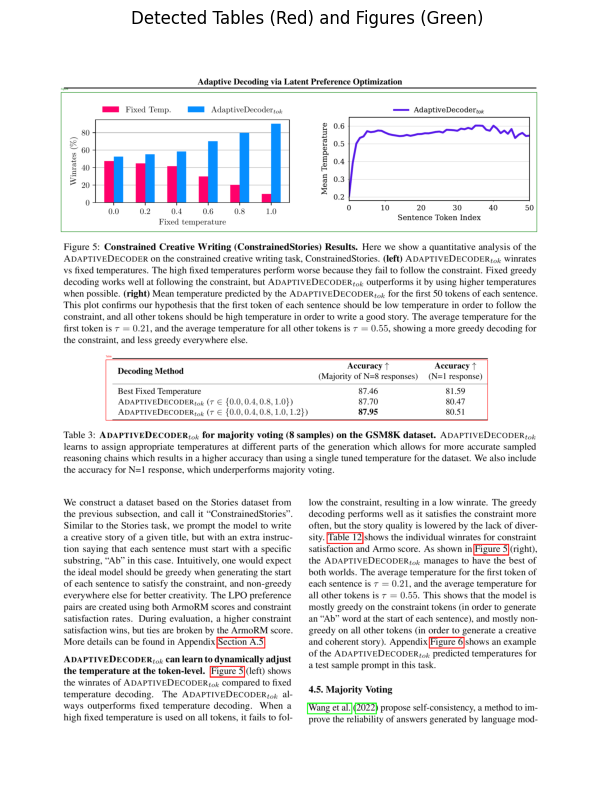

Found 1 tables and 1 figures


c:\Users\thinkpad\Documents\GitHub\Textra_ai_research_vc\venv\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.l

Detecting layout elements...


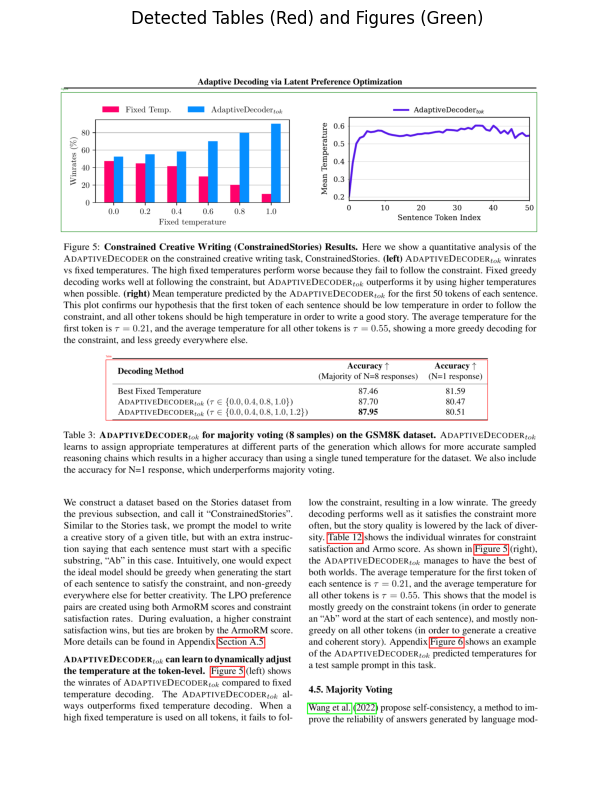

Found 1 tables and 1 figures


In [8]:
# First combination (More balanced)
result1 = process_single_page(
    image_path,
    table_threshold=0.3,
    figure_threshold=0.8
)
# Second combination (More strict figure detection)
result2 = process_single_page(
    image_path,
    table_threshold=0.1,
    figure_threshold=0.9
)

## Understanding the Thresholds

The detection thresholds control how confident the model needs to be to classify something as a table or figure:

- `table_threshold`: Lower values (e.g., 0.1-0.3) make the model more lenient in detecting tables
- `figure_threshold`: Higher values (e.g., 0.8-0.9) make the model more strict in detecting figures

This combination helps prevent misclassification of tables as figures.

## Common Issues and Solutions

1. **Double Detection**: If elements are being detected as both table and figure:
   - Increase the figure_threshold
   - Decrease the table_threshold
   - The overlap prevention system will take care of the rest

2. **Missed Tables**: If tables aren't being detected:
   - Lower the table_threshold
   - Try values between 0.1 and 0.3

3. **False Figure Detections**: If too many things are being detected as figures:
   - Increase the figure_threshold
   - Try values between 0.8 and 0.9